# Exploratory data analysis


**Dataset: 2,894 Facebook posts annotated with scores for valence and arousal**


Preoţiuc-Pietro, D., Schwartz, H. A., Park, G., Eichstaedt, J., Kern, M., Ungar, L., & Shulman, E. (2016): Modelling valence and arousal in facebook posts. In Proceedings of the 7th workshop on computational approaches to subjectivity, sentiment and social media analysis (pp. 9-15).

Dimensonal Emotion model based on the circumplex model (valence and arousal) by James A. Russell (1980): A Circumplex Model of Affect. Journal of Personality and Social Psychology (39,6:1161–1178).

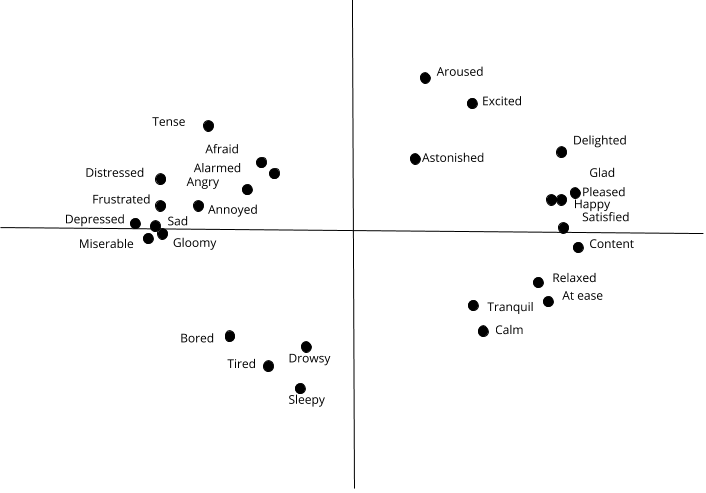

In [1]:
from IPython.display import Image
Image("russell.png", width=500, height=500)

## General corpus analysis 

- Number of observations – number of annotated examples in the dataset

### Row level

- Word count – number of words per observation
- Stop word count – number of stop words per observation
- Unique word count – number of unique words per observation
- URL count – number of urls per observation
- Mean word length – the  average word length (in characters) per observation
- Char count - number of characters per observation 
- Punctuation count – number of punctuations per observation
- Hashtag count – number of hashtags # per observation
- Mention count – number of user mentions @ per observation

### Corpus level

- Word count – number of words in the dataset
- Stop word count – number of stop words in the dataset
- Word count without stop words – number of words in the dataset excluding stop words
- Unique word count – number of unique words in the dataset
- Punctuation count – number of punctuations in the dataset
- User count – number of user mentions @ in the dataset
- Hashtag count – number of hashtags # in the dataset
- URL count – number of urls in the dataset
- Mean sequence len – the  average  observation  length  with  respect  to  all observations in the corpus


## Classes and scores

- Classes and scores – distribution and imbalance check

## Lexical analysis 

- N-gram frequency – number of unigrams, bigrams, trigrams
- Verbs
- Adjectives
- NER (random sample)
- Depenency grammar (random sample)
- Emotion words – occurrence of emotion words in the dataset based on a selected emotion lexicon
- LDA

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

import re
import string

import matplotlib.pyplot as plt
from wordcloud import STOPWORDS


SEED = 42

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [5]:
DIR = 'data/'
DATA = 'facebook/facebook.csv'

In [6]:
data = pd.read_csv(DIR + DATA, encoding='utf8')

print('Dataset Shape = {}'.format(data.shape))
print('Dataset Memory Usage = {:.2f} MB'.format(data.memory_usage().sum() / 1024**2))


Dataset Shape = (2895, 5)
Dataset Memory Usage = 0.11 MB


In [7]:
data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8
1,I really wana move soon!,4,5,5,7
2,thinking at charity cup,5,5,1,1
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7
4,Our Wedding Anniversary tonight...,7,7,4,5


### Missing values

In [8]:
data.isna().values.any()

True

In [9]:
data.isna().sum()

Anonymized Message    1
Valence1              0
Valence2              0
Arousal1              0
Arousal2              0
dtype: int64

In [10]:
data[data.isna().any(axis=1)]

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2
70,NaN,6,6,3,1


In [11]:
data = pd.DataFrame.dropna(data)
data.isna().values.any()

False

In [12]:
data.describe()

,Valence1,Valence2,Arousal1,Arousal2
count,2894.000000,2894.000000,2894.000000,2894.000000
mean,5.274015,5.250173,3.363856,3.343124
std,1.042098,1.485600,1.958775,2.183769
min,2.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,2.000000,1.000000
50%,5.000000,5.000000,3.000000,3.000000
75%,6.000000,6.000000,5.000000,5.000000
max,9.000000,9.000000,9.000000,9.000000


## General corpus analysis 

- Number of observations – number of annotated examples in the dataset

### Row level

- Word count – number of words per observation
- Stop word count – number of stop words per observation
- Unique word count – number of unique words per observation
- URL count – number of urls per observation
- Mean word length – the  average word length (in characters) per observation
- Char count - number of characters per observation 
- Punctuation count – number of punctuations per observation
- Hashtag count – number of hashtags # per observation
- Mention count – number of user mentions @ per observation

In [13]:
#number of observations
print(f'Dataset: {len(data)} observations') # checked with paper, correct

Dataset: 2894 observations


In [14]:
TEXT = 'Anonymized Message'

In [15]:
data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8
1,I really wana move soon!,4,5,5,7
2,thinking at charity cup,5,5,1,1
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7
4,Our Wedding Anniversary tonight...,7,7,4,5


In [16]:
data[TEXT][:20]

0     We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :)                                                                                                          
1     I really wana move soon!                                                                                                                                                                  
2     thinking at charity cup                                                                                                                                                                   
3     thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!                                                                                                     
4     Our Wedding Anniversary tonight...                                                                                                                                                        
5     Just sip some crystal with th

---
Seems like they anonymized names, user mentiones, etc. with PERSON - let's take a closer look.
    
---

In [17]:
txt_array = data[TEXT].values

In [18]:
len(txt_array)

2894

In [19]:
# checking for person

person_check = []
count = 0

for i in range(0,len(txt_array)):
    txt = txt_array[i].split()
    if '<PERSON>' in txt:
        person_check.append(txt_array[i]) 
    for token in txt:
        if token == '<PERSON>':
            count += 1

In [20]:
count

151

In [21]:
person_check

['So happy <PERSON> is the bomb',
 'Is exhausted. I think <PERSON> has colic. She wrenches her back and cries forever. Mostly in the morning though and right before bed. Ouy!',
 'Pancakes were apperantly good <PERSON> :D:D i hope we dont get sick after them :D',
 '<PERSON>       No matter what your party is, this is not the time to point fingers.  This woman and many other people were attacked by a person that should have been out of society.  I have everyone in my prayers to include <PERSON>, and I am a hardcore conservitive.  Remember that this is America and we can all think differently, this should not result in what happened today.  God be with you',
 'I have had a amazing day. Thanks for your encouragement <PERSON>. I am on fire. I then got to go to a christian concert in Sedalia to see <PERSON> he sings my savior lives. There was also <PLACE> Weave and it was life changing and wonderful and I am so thankful and blessed.',
 'Someone should make a <PERSON> Facts website to compete

In [22]:
len(person_check)

125

In [23]:
for i in txt_array:
    txt = re.findall(r'<PERSON>', i)
    if txt != []:
        print(txt)

['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>', '<PERSON>', '<PERSON>', '<PERSON>']
['<PERSON>', '<PERSON>', '<PERSON>', '<PERSON>', '<PERSON>', '<PERSON>']
['<PERSON>', '<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>', '<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON>']
['<PERSON

---
*Note: There must be some patterns that don't exactly match PERSON - check with regex*

---

In [24]:
# other patterns <*>

for i in txt_array:
    txt = re.findall(r'<(.+?)>', i)
    if txt != []:
        print(txt)

['PERSON']
['PERSON']
['PERSON']
['PERSON']
['URL']
['PERSON', 'PERSON']
['PERSON', 'PERSON', 'PLACE']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PHONE']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON', '3 <PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON']
['PHONE']
['PERSON']
['PERSON', 'PERSON']
['PERSON', 'PERSON', 'PERSON', 'PERSON']
['PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON']
['PERSON', 'PERSON', 'PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'PERSON']
['PERSON']
['URL']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['URL']
['PERSON']
['PERSON']
['PERSON']
['PERSON']
['PERSON', 'URL']
['EMAIL']
['PERSON. <333.......oh & <PERSON']
[

---
*Conclusion: There seem to be a lot of replacements for person, url, place, address, phone – double check with the original paper.*
    
---

In [25]:
# this only works if a whitespace follows the pattern and is only useful for quick checks and explicit patterns,
# otherwise use regex.

def check_patterns(text, pattern):    
    
    pattern_check = []
    pattern_count = 0
    
    for i in range(0,len(text)):
        txt = text[i].split()
        if pattern in txt:
            pattern_check.append(text[i]) 
        for token in txt:
            if token == pattern:
                pattern_count += 1
    
    print(f'Number of tokens: {pattern_count}')
    print(f'Number of observations: {len(pattern_check)}')
    print('______________________________________________')
    return pattern_check


--- 
*TODO: Ideally replace 'token == pattern" with regex – this is just for initial quick check.*

---

In [26]:
check_patterns(txt_array,'<URL>')

Number of tokens: 23
Number of observations: 23
______________________________________________


["ATTENTION EVERYONE---There's a site called <URL> that's a new online phone book w/personal information: everything from pics you've posted on FB or web, your approx credit score, home value, income, age, etc. You can remove yourself by first searching for yourself on their site to find the URL of your page, then going to the Privacy button on the bottom of their page to remove yourself. Copy & repost",
 'Tinychat time! Click the link to come me - <URL>  (tinychat.com)',
 "IÃ¢â‚¬â„¢m selling a '07 Mustang GT in Nitto 1320 Legends! <URL>",
 '<PERSON> 1:13-14           13 Let no one say when he is tempted, I am being tempted by God, for God cannot be tempted with evil, and he himself tempts no one. 14 But each person is tempted when he is lured and enticed by his own desire. #Bible <URL>',
 "Dr. Phil's Personality Test -- My Result: The Vain, Self-Centered Leader. <URL>",
 'OOO! OOO! OOO! OOO! Come On! <URL>',
 '<URL>',
 'I love this music video!!! <URL>',
 '10:26, man, iv been up a tol

In [27]:
check_patterns(txt_array,'@')

Number of tokens: 19
Number of observations: 16
______________________________________________


['Pizza reaches home faster than Ambulance & police,  Car loans @ 5% and education loan @ 12%, Rice is Rs 40/- per kg but SIM card is free, The footwear is sold in AC showrooms, but vegetables, that we eat, are sold on footpaths...Got to change something here...',
 "Okay, school being out isn't so bad...... been able to sleep 3 extra hours is AWESOME! Getting up @ 8 am is better than 5!",
 'Here I sit @ my computer, suffering with a head cold. While Lil <PERSON> watches SpongeBob.',
 "Yest nite @ 2 am earthquake in delhi, felt d tremors for d 1st tym in my lyf!!! Thank God I'm still Alive!!",
 "thanks to everbody that wished me a happy birthday today! @ <PERSON> : I'm lucky enough to avoid a Ms. Fry impromptu song :P",
 "Stupid computer still isn't fixed. Text me @ <PHONE>Hopefully it will be working by this weekend.",
 '@ home...just chillin...I needed to come home...',
 "is annoyed at her stupid neighbors for practicing piano @ 10 o'clock!!! go 2 sleep u freaks!",
 "College Night is 

In [28]:
check_patterns(txt_array,'#')

Number of tokens: 2
Number of observations: 2
______________________________________________


['got a new # if you want it let me know.',
 'guess whos back yeah its me da # 1 dj here at your facebook hahaha enjoy fam!!!!!!']

-------------------------
*Conclusion: @ is not an indicator for user mention, the best proxy might be \< PERSON \>*

--------------------

In [29]:
#word_count
data['word_count'] = data[TEXT].apply(lambda x: len(str(x).split()))

# stop_word_count
data['stop_word_count'] = data[TEXT].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# unique_word_count
data['unique_word_count'] = data[TEXT].apply(lambda x: len(set(str(x).split())))

# url_count
#data['url_count'] = data[TEXT].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
data['url_count'] = data[TEXT].apply(lambda x: len([w for w in str(x).split() if (re.findall(r'<URL>', w))]))

# mean_word_length
data['mean_word_length'] = data[TEXT].apply(lambda x: np.round(np.mean([len(w) for w in str(x).split()])))

# char_count
data['char_count'] = data[TEXT].apply(lambda x: len(str(x)))

# punctuation_count
data['punct_count'] = data[TEXT].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
data['hashtag_count'] = data[TEXT].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
#data['mention_count'] = data[TEXT].apply(lambda x: len([c for c in str(x) if c == '@']))
data['mention_count'] = data[TEXT].apply(lambda x: len([w for w in str(x).split() if (re.findall(r'<PERSON>', w))]))

In [30]:
data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,word_count,stop_word_count,unique_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8,15,7,15,0,4.0,80,7,0,0
1,I really wana move soon!,4,5,5,7,5,1,5,0,4.0,24,1,0,0
2,thinking at charity cup,5,5,1,1,4,1,4,0,5.0,23,0,0,0
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7,15,6,15,0,5.0,85,5,0,0
4,Our Wedding Anniversary tonight...,7,7,4,5,4,1,4,0,8.0,34,3,0,0


In [31]:
# quick double check mention count

data['mention_count'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    1
Name: mention_count, dtype: int64

In [32]:
data.iloc[9]

Anonymized Message    So happy <PERSON> is the bomb
Valence1              6                            
Valence2              8                            
Arousal1              5                            
Arousal2              3                            
word_count            6                            
stop_word_count       3                            
unique_word_count     6                            
url_count             0                            
mean_word_length      4                            
char_count            29                           
punct_count           2                            
hashtag_count         0                            
mention_count         1                            
Name: 9, dtype: object

In [33]:
# quick double check word count

print(str(data[TEXT][9]).split())
len(str(data[TEXT][9]).split())

['So', 'happy', '<PERSON>', 'is', 'the', 'bomb']


6

In [34]:
# quick double check char count

chars = []
for i in data[TEXT][9]:
        chars.append(i)

len(chars)

29

## General corpus analysis

### Corpus level

- Word count – number of words in the dataset
- Stop word count – number of stop words in the dataset
- Word count without stop words – number of words in the dataset excluding stop words
- Unique word count – number of unique words in the dataset
- Punctuation count – number of punctuations in the dataset
- User count – number of user mentions @ in the dataset
- Hashtag count – number of hashtags # in the dataset
- URL count – number of urls in the dataset
- Mean sequence len – the  average  observation  length  with  respect  to  all observations in the corpus


In [35]:
word_count = data['word_count'].sum()
stop_word_count = data['stop_word_count'].sum()

no_stopwords = data[TEXT].apply(lambda x: len([w for w in str(x).lower().split() if w not in STOPWORDS])).sum()

punctuation_count = data['punct_count'].sum()
user_count = data['mention_count'].sum()
hashtag_count = data['hashtag_count'].sum()
url_count = data['url_count'].sum()
mean_seq_len = data['word_count'].mean()

print(f'Word count: {word_count}')
print(f'Stop word count: {stop_word_count}')
print(f'Word count without stop words: {no_stopwords}')
print(f'Punctuation count: {punctuation_count}')
print(f'User count : {user_count}')
print(f'Hashtag count: {hashtag_count}')
print(f'URL count: {url_count}')
print(f'Mean sequence length: {mean_seq_len}')

Word count: 46868
Stop word count: 20414
Word count without stop words: 26454
Punctuation count: 15351
User count : 265
Hashtag count: 13
URL count: 24
Mean sequence length: 16.19488597097443


In [36]:
# unique tokens

unique_tokens = []

def check_unique_tokens(documents):  
    
    for i in range(0, len(documents)):    
        observation = documents[i].split() 
        for token in observation:
            if token not in unique_tokens:
                unique_tokens.append(token)
                
    print(f'Number of unique tokens in the corpus: {len(unique_tokens)}')


In [37]:
txt = data[TEXT].values

In [38]:
unique = check_unique_tokens(txt)

unique_no_stw = []

for i in unique_tokens:
    if i not in STOPWORDS:
        unique_no_stw.append(i)

print(f'Number of unique tokens without stopwords in the corpus: {len(unique_no_stw)}')

Number of unique tokens in the corpus: 12094
Number of unique tokens without stopwords in the corpus: 11928


## Classes and scores

- Classes and scores – distribution and imbalance check

In this case we're checking scores for valence and arousal separately.

### High-low split

In [39]:
data['Valence'] = data[['Valence1', 'Valence2']].mean(axis=1)
data['Arousal'] = data[['Arousal1', 'Arousal2']].mean(axis=1)
data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,word_count,stop_word_count,unique_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count,Valence,Arousal
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8,15,7,15,0,4.0,80,7,0,0,9.0,8.0
1,I really wana move soon!,4,5,5,7,5,1,5,0,4.0,24,1,0,0,4.5,6.0
2,thinking at charity cup,5,5,1,1,4,1,4,0,5.0,23,0,0,0,5.0,1.0
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7,15,6,15,0,5.0,85,5,0,0,3.5,6.5
4,Our Wedding Anniversary tonight...,7,7,4,5,4,1,4,0,8.0,34,3,0,0,7.0,4.5


In [40]:
# Splitting into high and low valence is giving a rough estimate on the 
# distribution of positive and negative observations

data.loc[data['Valence'] <= 4.5, 'Valence high/low'] = 0 
data.loc[data['Valence'] > 4.5, 'Valence high/low'] = 1 
data.loc[data['Arousal'] <= 4.5, 'Arousal high/low'] = 0 
data.loc[data['Arousal'] > 4.5, 'Arousal high/low'] = 1 

data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,word_count,stop_word_count,unique_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count,Valence,Arousal,Valence high/low,Arousal high/low
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8,15,7,15,0,4.0,80,7,0,0,9.0,8.0,1.0,1.0
1,I really wana move soon!,4,5,5,7,5,1,5,0,4.0,24,1,0,0,4.5,6.0,0.0,1.0
2,thinking at charity cup,5,5,1,1,4,1,4,0,5.0,23,0,0,0,5.0,1.0,1.0,0.0
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7,15,6,15,0,5.0,85,5,0,0,3.5,6.5,0.0,1.0
4,Our Wedding Anniversary tonight...,7,7,4,5,4,1,4,0,8.0,34,3,0,0,7.0,4.5,1.0,0.0


High valence (1) and low valence (0) distribution.
 
–––––––––––––––––––––––––––––––––––––––––––
1.0    2117
0.0    777 
Name: Valence high/low, dtype: int64
–––––––––––––––––––––––––––––––––––––––––––
 


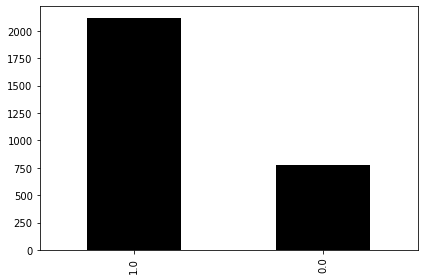

In [41]:
print('High valence (1) and low valence (0) distribution.')
data['Valence high/low'].value_counts().plot(kind="bar", color='k')
plt.tight_layout()

print(' ')
print('–––––––––––––––––––––––––––––––––––––––––––')
print(data['Valence high/low'].value_counts())
print('–––––––––––––––––––––––––––––––––––––––––––')
print(' ')


High arousal (1) and low arousal (0) distribution.
 
–––––––––––––––––––––––––––––––––––––––––––
0.0    2106
1.0    788 
Name: Arousal high/low, dtype: int64
–––––––––––––––––––––––––––––––––––––––––––
 


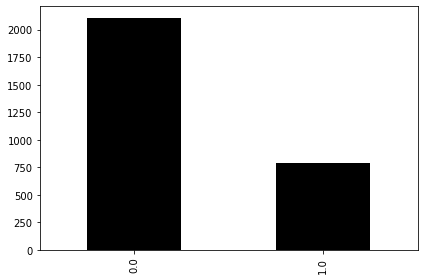

In [42]:
print('High arousal (1) and low arousal (0) distribution.')
data['Arousal high/low'].value_counts().plot(kind="bar", color='k')
plt.tight_layout()


print(' ')
print('–––––––––––––––––––––––––––––––––––––––––––')
print(data['Arousal high/low'].value_counts())
print('–––––––––––––––––––––––––––––––––––––––––––')
print(' ')


In [43]:
df1 = data['Arousal high/low'].value_counts()
df2 = data['Valence high/low'].value_counts()
df_comb = df1.to_frame().join(df2.to_frame())

df_comb.style.bar(color='#84DDD6')

,Arousal high/low,Valence high/low
0.0,2106,777
1.0,788,2117


---
*Note: High number of observations for high valence (pos) and low arousal, whereas a lot less observations for the opposites.*
    
---

Fine-grained valence distribution.


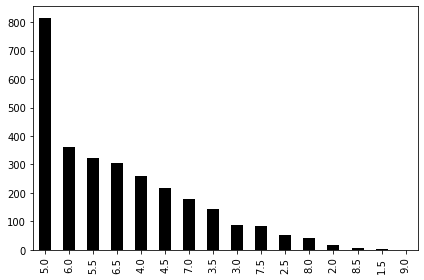

In [44]:
print('Fine-grained valence distribution.')
data['Valence'].value_counts().plot(kind="bar", color='k')
plt.tight_layout()

Fine-grained arousal distribution.


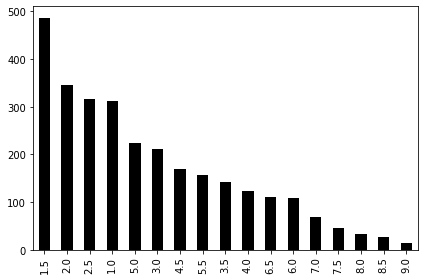

In [45]:
print('Fine-grained arousal distribution.')
data['Arousal'].value_counts().plot(kind="bar", color='k')
plt.tight_layout()

In [46]:
df1_arousal = data['Arousal'].value_counts()
df2_arousal = data['Valence'].value_counts()
df_comb_arousal = df1_arousal.to_frame().join(df2_arousal.to_frame())
df_comb_arousal.style.bar(color='#84DDD6')

,Arousal,Valence
1.5,486,2
2.0,345,16
2.5,316,51
1.0,313,nan
5.0,223,815
3.0,211,86
4.5,169,218
5.5,156,324
3.5,143,144
4.0,123,260


In [47]:
lst_low_arousal = []
for i in range(0,len(data)):
    if data['Arousal'].iloc[i] == 1.5:
        lst_low_arousal.append(data.iloc[i])

In [48]:
len(lst_low_arousal)

486

In [49]:
df_lst_low_arousal = pd.DataFrame(lst_low_arousal, columns = ['Anonymized Message', 'Arousal1','Arousal2','Valence1','Valence2'])
df_lst_low_arousal

,Anonymized Message,Arousal1,Arousal2,Valence1,Valence2
23,3 more days,2,1,5,5
24,got a new # if you want it let me know.,2,1,5,5
43,is contemplating how to spend his Xbox points...,2,1,5,5
58,is fixin' to have a party this halloween.,2,1,6,5
63,Someone should make a <PERSON> Facts website to compete against Chuck Norris.,2,1,5,5
66,A life of wisdom consists of being constantly engaged in letting go,2,1,5,5
79,patiently waiting out the days,2,1,4,5
82,Ok. All done with the beach today. Might do the Promenade tonight or tomorrow.,2,1,6,5
83,6 hrs until mid night release for black ops.,2,1,6,6
88,has nothing on her mind.,2,1,5,5


In [50]:
data.index[1]

1

In [51]:
frame = [data['Anonymized Message'],data['Valence1'],data['Valence2'],data['Arousal1'],data['Arousal2'],data['Valence'], data['Arousal'], data['Valence high/low'], data['Arousal high/low']]
random_sample_analysis = pd.concat(frame, axis=1)

In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

random_sample_analysis.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,Valence,Arousal,Valence high/low,Arousal high/low
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8,9.0,8.0,1.0,1.0
1,I really wana move soon!,4,5,5,7,4.5,6.0,0.0,1.0
2,thinking at charity cup,5,5,1,1,5.0,1.0,1.0,0.0
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7,3.5,6.5,0.0,1.0
4,Our Wedding Anniversary tonight...,7,7,4,5,7.0,4.5,1.0,0.0


### Check random sample for inter-annotator agreement

In [53]:
random_sample_analysis[1500:1515]

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,Valence,Arousal,Valence high/low,Arousal high/low
1501,"Shout Out To Melpo !! Love The 4X0T308Look , You FULLY Rock =P Cyaaz In English !!",7,8,7,6,7.5,6.5,1.0,1.0
1502,crna :),6,6,1,3,6.0,2.0,1.0,0.0
1503,It's a sad day in Patriots land today. I Guess that's what I get for talking so much smack.,4,4,2,1,4.0,1.5,0.0,0.0
1504,is it too early to be relaxing sipping on a long neck CORONA? *hick* : ),6,6,2,4,6.0,3.0,1.0,0.0
1505,i tried to do farm pals but i need to download adobe flash player and that wont work on my computor =(,4,4,2,3,4.0,2.5,0.0,0.0
1506,2010 blink and you will miss it its flying along time machine anyone.....,5,5,1,3,5.0,2.0,1.0,0.0
1507,2 days til I'm back in the US baby!,7,6,5,5,6.5,5.0,1.0,1.0
1508,"The worst way to miss someone is \t\twhen they are right beside you and yet you know you can never have them.\\""""",3,2,2,1,2.5,1.5,0.0,0.0
1509,Getting bored of facebook.............. x_______x,4,4,1,4,4.0,2.5,0.0,0.0
1510,thank you to whoever it was that sent the roses from Malaysia...there was no name so im just saying a general thank you to everyone....pics will be up soon....xox,6,6,2,3,6.0,2.5,1.0,0.0


### Stats

In [54]:
df = data[['Valence', 'Arousal','word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punct_count', 'hashtag_count', 'mention_count']]

In [55]:
df.head()

,Valence,Arousal,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count
0,9.0,8.0,15,15,7,0,4.0,80,7,0,0
1,4.5,6.0,5,5,1,0,4.0,24,1,0,0
2,5.0,1.0,4,4,1,0,5.0,23,0,0,0
3,3.5,6.5,15,15,6,0,5.0,85,5,0,0
4,7.0,4.5,4,4,1,0,8.0,34,3,0,0


In [56]:
mean_df = pd.DataFrame(df.mean())
mean_df = mean_df.rename(columns={0: "Mean"})
mean_df

,Mean
Valence,5.262094
Arousal,3.353490
word_count,16.194886
unique_word_count,14.589150
stop_word_count,7.053905
url_count,0.008293
mean_word_length,4.818590
char_count,86.907740
punct_count,5.304423
hashtag_count,0.004492


In [57]:
df.describe()

,Valence,Arousal,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count
count,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000
mean,5.262094,3.353490,16.194886,14.589150,7.053905,0.008293,4.818590,86.907740,5.304423,0.004492,0.091569
std,1.190679,1.980407,14.894677,12.049967,7.659122,0.090703,3.393827,79.072004,6.361144,0.066884,0.384964
min,1.500000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,4.500000,1.500000,6.000000,6.000000,2.000000,0.000000,4.000000,35.000000,2.000000,0.000000,0.000000
50%,5.000000,2.500000,11.000000,11.000000,5.000000,0.000000,4.000000,62.000000,4.000000,0.000000,0.000000
75%,6.000000,5.000000,20.000000,19.000000,9.000000,0.000000,5.000000,108.750000,7.000000,0.000000,0.000000
max,9.000000,9.000000,148.000000,70.000000,50.000000,1.000000,102.000000,697.000000,86.000000,1.000000,6.000000


## Lexical analysis 

- N-gram frequency – number of unigrams, bigrams, trigrams
- Verbs
- Adjectives
- NER (random sample)
- Depenency grammar (random sample)
- Emotion words – occurrence of emotion words in the dataset based on a selected emotion lexicon
- LDA

### N-gram frequency – number of unigrams, bigrams, trigrams


In [58]:
from sklearn.feature_extraction.text import CountVectorizer

lexical = data[TEXT].values

In [59]:
def ngram_frequency(documents, MAX, NGRAMS, STOP, NUM_WORDS):
    
    cv = CountVectorizer(max_features = MAX, stop_words=STOP, ngram_range=NGRAMS)
    X = cv.fit_transform(documents).toarray()
    
    occ = np.asarray(X.sum(axis=0)).ravel().tolist()
    counts_df = pd.DataFrame({'word': cv.get_feature_names(), 'occurrences': occ}).reset_index(drop=True)
    df = counts_df.sort_values(by='occurrences', ascending=False).head(NUM_WORDS)
    
    return df.reset_index(drop=True).style.bar(color='#84DDD6')

In [60]:
ngram_frequency(lexical, MAX = 5000, NGRAMS = (1,1), STOP = 'english', NUM_WORDS = 20)

,word,occurrences
0,person,301
1,just,234
2,day,229
3,love,177
4,like,169
5,time,155
6,got,154
7,today,150
8,birthday,149
9,happy,124


In [61]:
ngram_frequency(lexical, MAX = 5000, NGRAMS = (2,2), STOP = 'english', NUM_WORDS = 20)

,word,occurrences
0,birthday wishes,52
1,person person,49
2,h8 ha,48
3,ha h8,47
4,thanks birthday,35
5,just got,34
6,happy birthday,30
7,great day,21
8,copy paste,20
9,getting ready,15


In [62]:
ngram_frequency(lexical, MAX = 5000, NGRAMS = (3,3), STOP = 'english', NUM_WORDS = 20)

,word,occurrences
0,h8 ha h8,47
1,ha h8 ha,47
2,thanks birthday wishes,26
3,person person person,16
4,thank birthday wishes,10
5,wished happy birthday,9
6,thanks day wishes,8
7,copy paste status,6
8,birthday wishes great,5
9,won copy paste,5


### Verbs and adjectives

In [63]:
data.head()

,Anonymized Message,Valence1,Valence2,Arousal1,Arousal2,word_count,stop_word_count,unique_word_count,url_count,mean_word_length,char_count,punct_count,hashtag_count,mention_count,Valence,Arousal,Valence high/low,Arousal high/low
0,We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :),9,9,8,8,15,7,15,0,4.0,80,7,0,0,9.0,8.0,1.0,1.0
1,I really wana move soon!,4,5,5,7,5,1,5,0,4.0,24,1,0,0,4.5,6.0,0.0,1.0
2,thinking at charity cup,5,5,1,1,4,1,4,0,5.0,23,0,0,0,5.0,1.0,1.0,0.0
3,"thinks that for girls, boys are easily found. But GIRLS don't realize they need MEN!!",4,3,6,7,15,6,15,0,5.0,85,5,0,0,3.5,6.5,0.0,1.0
4,Our Wedding Anniversary tonight...,7,7,4,5,4,1,4,0,8.0,34,3,0,0,7.0,4.5,1.0,0.0


In [64]:
lexical

array(["We'll be off and running to a lil' place called SILVERWOOD today! Can't wait! :)",
       'I really wana move soon!', 'thinking at charity cup', ...,
       'lbing',
       'Well i would like to inform my friends, family: things are important in any relationship. 1: God, 2: Respect, 3: Communication, any breakdown of those things listed,you will have issues, and drama!!',
       'school in 2 minutes.... lol'], dtype=object)

In [65]:
lexical_full = ' '.join(map(str, lexical)) 
lexical_sample = ' '.join(map(str, lexical[1500:1515])) 

In [66]:
lexical_sample

'Shout Out To Melpo !! Love The 4X0T308Look , You FULLY Rock =P Cyaaz In English !! crna :) It\'s a sad day in Patriots land today. I Guess that\'s what I get for talking so much smack. is it too early to be relaxing sipping on a long neck CORONA? *hick* : ) i tried to do farm pals but i need to download adobe flash player and that wont work on my computor =( 2010 blink and you will miss it its flying along time machine anyone..... 2 days til I\'m back in the US baby! The worst way to miss someone is \t\twhen they are right beside you and yet you know you can never have them.\\\\"" Getting bored of facebook.............. x_______x thank you to whoever it was that sent the roses from Malaysia...there was no name so im just saying a general thank you to everyone....pics will be up soon....xox fixin 2 go crazy blaaaaaaaaaa i just did bamaboyz 4 life not feeling well... @_@ R.I.P.<PERSON> i\'m not dirty as yo think I am! Blank'

In [67]:
import en_core_web_sm

In [68]:
nlp = en_core_web_sm.load()
doc = nlp(lexical_full)

In [69]:
verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]

In [70]:
print(f'Number of adjectives:          {(len(adjectives))}')
print(f'Number of unique adjectives:   {len(set(adjectives))}')
print(f'Number of verbs:               {len(verbs)}')
print(f'Number of unique verbs:        {len(set(verbs))}')

Number of adjectives:          3085
Number of unique adjectives:   776
Number of verbs:               7283
Number of unique verbs:        1101


In [71]:
adjectives[100:120]

['mid',
 'black',
 'many',
 'happy',
 'late',
 'magical',
 'first',
 'weary',
 'faint',
 'alien',
 'free',
 'med',
 'loose',
 'unmarked',
 'remote',
 'great',
 'alive',
 'many',
 'first',
 'first']

In [72]:
verbs[100:120]

['get',
 'finish',
 'hurt',
 'come',
 'perform',
 'look',
 'focus',
 'focus',
 'focus',
 'think',
 'would',
 'happen',
 'ask',
 'have',
 'smile',
 'go',
 'happen',
 'fall',
 'drive',
 'cape']

In [73]:
from collections import Counter, OrderedDict

count_verbs = Counter(verbs)
count_adjectives = Counter(adjectives)

In [74]:
count_verbs.most_common(20)

[('go', 336),
 ('get', 270),
 ('will', 227),
 ('can', 213),
 ('be', 156),
 ('make', 137),
 ('know', 135),
 ('think', 123),
 ('want', 118),
 ('love', 117),
 ('see', 117),
 ('wish', 117),
 ('would', 107),
 ('need', 101),
 ('say', 98),
 ('come', 96),
 ('take', 93),
 ('feel', 86),
 ('thank', 81),
 ('look', 76)]

In [75]:
most_common_verbs_dict = OrderedDict(count_verbs.most_common()) # creates a dictionary of all verbs as keys and their counts as values

In [76]:
count_adjectives.most_common(20)

[('good', 157),
 ('great', 100),
 ('happy', 91),
 ('new', 81),
 ('more', 65),
 ('bad', 52),
 ('last', 49),
 ('little', 44),
 ('many', 43),
 ('ready', 42),
 ('well', 42),
 ('old', 40),
 ('tired', 39),
 ('sick', 37),
 ('next', 36),
 ('much', 33),
 ('long', 33),
 ('nice', 32),
 ('other', 32),
 ('beautiful', 30)]

In [77]:
most_common_adjectives_dict = OrderedDict(count_adjectives.most_common())

### Most common verbs side by side

In [78]:
most_common_verbs_df = pd.DataFrame.from_dict(most_common_verbs_dict, orient='index', columns=['Verb // Count'])

In [79]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [80]:
most_common_verbs_df.head()

,Verb // Count
go,336
get,270
will,227
can,213
be,156


In [81]:
df1_verbs = most_common_verbs_df[0:10]
df2_verbs = most_common_verbs_df[10:20]
df3_verbs = most_common_verbs_df[20:30]

display_side_by_side(df1_verbs, df2_verbs, df3_verbs)

,Verb // Count
go,336
get,270
will,227
can,213
be,156
make,137
know,135
think,123
want,118
love,117


### Most common adjectives side by side

In [82]:
most_common_adjectives_df = pd.DataFrame.from_dict(most_common_adjectives_dict, orient='index', columns=['Adjectives // Count'])

In [83]:
df1_adjectives = most_common_adjectives_df[0:10]
df2_adjectives = most_common_adjectives_df[10:20]
df3_adjectives = most_common_adjectives_df[20:30]

display_side_by_side(df1_adjectives,df2_adjectives,df3_adjectives)

,Adjectives // Count
good,157
great,100
happy,91
new,81
more,65
bad,52
last,49
little,44
many,43
ready,42


### POS tags

In [84]:
nlp = en_core_web_sm.load()
doc = nlp(lexical_sample)

In [85]:
pos_df = pd.DataFrame()

for token in doc:
    pos_tags = pd.DataFrame({'TEXT': token.text, 'LEMMA': token.lemma_, 'POS': token.pos_, 'TAG': token.tag_, 'DEP': token.dep_,
            'SHAPE': token.shape_, 'ALPHA': token.is_alpha, 'STOP': token.is_stop}, index=[0])

    pos_df = pd.concat([pos_df, pos_tags])
    
pos_df.head(20)

,TEXT,LEMMA,POS,TAG,DEP,SHAPE,ALPHA,STOP
0,Shout,shout,VERB,VB,ROOT,Xxxxx,True,False
0,Out,out,ADP,RP,prt,Xxx,True,True
0,To,to,ADP,IN,prep,Xx,True,True
0,Melpo,Melpo,PROPN,NNP,pobj,Xxxxx,True,False
0,!,!,PUNCT,.,punct,!,False,False
0,!,!,PUNCT,.,punct,!,False,False
0,Love,love,VERB,VB,ROOT,Xxxx,True,False
0,The,the,DET,DT,det,Xxx,True,True
0,4X0T308Look,4x0t308look,NOUN,NN,dobj,dXdXdddXxxx,False,False
0,",",",",PUNCT,",",punct,",",False,False


*Note on SpaCy POS tags:*
- Text: The original word text.
- Lemma: The base form of the word.
- POS: The simple part-of-speech tag.
- Tag: The detailed part-of-speech tag.
- Dep: Syntactic dependency, i.e. the relation between tokens.
- Shape: The word shape – capitalization, punctuation, digits.
- is alpha: Is the token an alpha character?
- is stop: Is the token part of a stop list, i.e. the most common words of the language?

--- 
*TODO: Find a way to visualize this better - if necessary, take a look observationwise.*
    
---

### NER (random sample)

In [86]:
doc

Shout Out To Melpo !! Love The 4X0T308Look , You FULLY Rock =P Cyaaz In English !! crna :) It's a sad day in Patriots land today. I Guess that's what I get for talking so much smack. is it too early to be relaxing sipping on a long neck CORONA? *hick* : ) i tried to do farm pals but i need to download adobe flash player and that wont work on my computor =( 2010 blink and you will miss it its flying along time machine anyone..... 2 days til I'm back in the US baby! The worst way to miss someone is 		when they are right beside you and yet you know you can never have them.\\"" Getting bored of facebook.............. x_______x thank you to whoever it was that sent the roses from Malaysia...there was no name so im just saying a general thank you to everyone....pics will be up soon....xox fixin 2 go crazy blaaaaaaaaaa i just did bamaboyz 4 life not feeling well... @_@ R.I.P.<PERSON> i'm not dirty as yo think I am! Blank

In [87]:
named_ent = []
named_label = []
for entity in doc.ents:
    named_ent.append(entity.text)
    named_label.append(entity.label_)

In [88]:
print(f'Named entities: {len(named_ent)}')
print(f'Entity labels: {len(named_label)}')

print(f'–––––––––––––––––––––––––––––––––––––––')

print(f'Unique named entities: {len(set(named_ent))}')
print(f'Unique entity labels: {len(set(named_label))}')

Named entities: 13
Entity labels: 13
–––––––––––––––––––––––––––––––––––––––
Unique named entities: 13
Unique entity labels: 6


In [89]:
for entity in doc.ents:
    print(entity.text, entity.label_)

English LANGUAGE
crna PERSON
Patriots ORG
today DATE
2010 DATE
2 days DATE
US GPE
x_______x GPE
Malaysia GPE
xox PERSON
2 CARDINAL
4 CARDINAL
yo PERSON


In [90]:
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

--- 
*Note: This is not very good - missing e.g. Melpo, CORONA, adobe flash player - mistakes e.g. x_______x, xox, yo*
- *TODO: Check other samples*
- *TODO: Cross check with NLTK*

---

### NER (numbers full corpus)

In [91]:
nlp = en_core_web_sm.load()
doc_full = nlp(lexical_full)

In [92]:
named_ent_full = []
named_label_full = []

for entity in doc_full.ents:
    named_ent_full.append(entity.text)
    named_label_full.append(entity.label_)

In [93]:
print(f'Named entities: {len(named_ent_full)}')
print(f'Entity labels: {len(named_label_full)}')

print(f'–––––––––––––––––––––––––––––––––––––––')

print(f'Unique named entities: {len(set(named_ent_full))}')
print(f'Unique entity labels: {len(set(named_label_full))}')

Named entities: 2775
Entity labels: 2775
–––––––––––––––––––––––––––––––––––––––
Unique named entities: 1763
Unique entity labels: 17


In [94]:
named_label_full[100:130]

['TIME',
 'TIME',
 'ORDINAL',
 'WORK_OF_ART',
 'DATE',
 'CARDINAL',
 'DATE',
 'PERSON',
 'DATE',
 'PERSON',
 'DATE',
 'DATE',
 'PERSON',
 'DATE',
 'PERSON',
 'PERSON',
 'TIME',
 'CARDINAL',
 'CARDINAL',
 'ORG',
 'FAC',
 'QUANTITY',
 'CARDINAL',
 'DATE',
 'TIME',
 'TIME',
 'DATE',
 'DATE',
 'ORG',
 'FAC']

In [95]:
# check samples
ent_dict = dict(zip(named_ent_full[100:130], named_label_full[100:130]))

In [96]:
ent_dict

{'six hours': 'TIME',
 '5:00 to 6:00 pm': 'TIME',
 'first': 'ORDINAL',
 'The Love of God\\.': 'WORK_OF_ART',
 '90s': 'DATE',
 'weekends': 'CARDINAL',
 'summer': 'DATE',
 'Yay': 'PERSON',
 'friday': 'DATE',
 'Jesus': 'PERSON',
 '2,010 years': 'DATE',
 '341 days ago': 'DATE',
 'JESUS': 'PERSON',
 'yesterday': 'DATE',
 'Eww': 'PERSON',
 'Very Fat Shh': 'PERSON',
 'night': 'TIME',
 'one': 'CARDINAL',
 'LA Gone': 'ORG',
 'Greenway': 'FAC',
 '2.5 mile': 'QUANTITY',
 '10': 'CARDINAL',
 '20 years ago': 'DATE',
 'a night': 'TIME',
 'tonight': 'TIME',
 '4 days': 'DATE',
 'day 1': 'DATE',
 'WTF': 'ORG',
 'Hyeholde': 'FAC'}

---
*Note: Several incorrect labels*
    
---

### Quick check NLTK POS tags

In [97]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

In [98]:
def preprocess_pos(document):
    document = nltk.word_tokenize(document)
    document = nltk.pos_tag(document)
    return document

In [99]:
lexical_sample_nltk_pos = preprocess_pos(lexical_sample)
lexical_sample_nltk_pos

[('Shout', 'RB'),
 ('Out', 'NNP'),
 ('To', 'TO'),
 ('Melpo', 'VB'),
 ('!', '.'),
 ('!', '.'),
 ('Love', 'VB'),
 ('The', 'DT'),
 ('4X0T308Look', 'CD'),
 (',', ','),
 ('You', 'PRP'),
 ('FULLY', 'VBP'),
 ('Rock', 'NNP'),
 ('=P', 'NNP'),
 ('Cyaaz', 'NNP'),
 ('In', 'IN'),
 ('English', 'NNP'),
 ('!', '.'),
 ('!', '.'),
 ('crna', 'NN'),
 (':', ':'),
 (')', ')'),
 ('It', 'PRP'),
 ("'s", 'VBZ'),
 ('a', 'DT'),
 ('sad', 'JJ'),
 ('day', 'NN'),
 ('in', 'IN'),
 ('Patriots', 'NNP'),
 ('land', 'NN'),
 ('today', 'NN'),
 ('.', '.'),
 ('I', 'PRP'),
 ('Guess', 'VBP'),
 ('that', 'DT'),
 ("'s", 'VBZ'),
 ('what', 'WP'),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('for', 'IN'),
 ('talking', 'VBG'),
 ('so', 'RB'),
 ('much', 'JJ'),
 ('smack', 'NN'),
 ('.', '.'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('too', 'RB'),
 ('early', 'JJ'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('relaxing', 'VBG'),
 ('sipping', 'VBG'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('long', 'JJ'),
 ('neck', 'NN'),
 ('CORONA', 'NNP'),
 ('?', '.'),
 ('*hick*', 'NN'),
 (':', ':

#### Common NLTK NER types

- NE Type	Examples
- ORGANIZATION	Georgia-Pacific Corp., WHO
- PERSON	Eddy Bonte, President Obama
- LOCATION	Murray River, Mount Everest
- DATE	June, 2008-06-29
- TIME	two fifty a m, 1:30 p.m.
- MONEY	175 million Canadian Dollars, GBP 10.40
- PERCENT	twenty pct, 18.75 %
- FACILITY	Washington Monument, Stonehenge
- GPE	South East Asia, Midlothian

In [100]:
# NLTK NER
print(ne_chunk(lexical_sample_nltk_pos))

(S
  Shout/RB
  Out/NNP
  To/TO
  Melpo/VB
  !/.
  !/.
  Love/VB
  The/DT
  4X0T308Look/CD
  ,/,
  You/PRP
  FULLY/VBP
  (PERSON Rock/NNP =P/NNP Cyaaz/NNP)
  In/IN
  (GPE English/NNP)
  !/.
  !/.
  crna/NN
  :/:
  )/)
  It/PRP
  's/VBZ
  a/DT
  sad/JJ
  day/NN
  in/IN
  (GPE Patriots/NNP)
  land/NN
  today/NN
  ./.
  I/PRP
  Guess/VBP
  that/DT
  's/VBZ
  what/WP
  I/PRP
  get/VBP
  for/IN
  talking/VBG
  so/RB
  much/JJ
  smack/NN
  ./.
  is/VBZ
  it/PRP
  too/RB
  early/JJ
  to/TO
  be/VB
  relaxing/VBG
  sipping/VBG
  on/IN
  a/DT
  long/JJ
  neck/NN
  (ORGANIZATION CORONA/NNP)
  ?/.
  *hick*/NN
  :/:
  )/)
  i/NN
  tried/VBD
  to/TO
  do/VB
  farm/NN
  pals/NNS
  but/CC
  i/NNS
  need/VBP
  to/TO
  download/VB
  adobe/NN
  flash/NN
  player/NN
  and/CC
  that/IN
  wont/JJ
  work/NN
  on/IN
  my/PRP$
  computor/NN
  =/NN
  (/(
  2010/CD
  blink/NN
  and/CC
  you/PRP
  will/MD
  miss/VB
  it/PRP
  its/PRP$
  flying/VBG
  along/JJ
  time/NN
  machine/NN
  anyone/NN
  .../:
  ../VBZ
  

---
*Note & TODO: Check out the following blog posts https://nlpforhackers.io/named-entity-extraction/ and https://nlpforhackers.io/training-pos-tagger/ for training a POS tagger and NER chunker – could be useful.*
            
---

### Dependency grammar (random sample) -- back to SpaCy

In [101]:
lexical_sample

'Shout Out To Melpo !! Love The 4X0T308Look , You FULLY Rock =P Cyaaz In English !! crna :) It\'s a sad day in Patriots land today. I Guess that\'s what I get for talking so much smack. is it too early to be relaxing sipping on a long neck CORONA? *hick* : ) i tried to do farm pals but i need to download adobe flash player and that wont work on my computor =( 2010 blink and you will miss it its flying along time machine anyone..... 2 days til I\'m back in the US baby! The worst way to miss someone is \t\twhen they are right beside you and yet you know you can never have them.\\\\"" Getting bored of facebook.............. x_______x thank you to whoever it was that sent the roses from Malaysia...there was no name so im just saying a general thank you to everyone....pics will be up soon....xox fixin 2 go crazy blaaaaaaaaaa i just did bamaboyz 4 life not feeling well... @_@ R.I.P.<PERSON> i\'m not dirty as yo think I am! Blank'

In [102]:
nlp = en_core_web_sm.load()
doc = nlp(lexical_sample)

In [103]:
type(doc)

spacy.tokens.doc.Doc

In [104]:
displacy.render(doc, style="dep")

### Emotion words – occurrence of emotion words in the dataset based on a selected emotion lexicon

In [105]:
PATH = 'data/lexicons/nrc_affect_intensity_lexicon.txt'

In [106]:
lexicon = pd.read_csv(PATH, encoding='utf8', delimiter='\t')

In [107]:
lexicon.head()

,term,score,AffectDimension
0,outraged,0.964,anger
1,brutality,0.959,anger
2,hatred,0.953,anger
3,hateful,0.940,anger
4,terrorize,0.939,anger


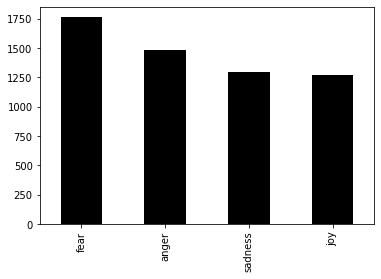

In [108]:
lexicon['AffectDimension'].value_counts().plot(kind="bar", color='k')

In [109]:
len(lexicon)

5814

In [110]:
emotion_words = []
emotion_lexicon_list = lexicon['term'].values

for i in range(0,len(lexical)):
    text = lexical[i].split()
    for token in text:
        if token in emotion_lexicon_list:
            emotion_words.append(token)

In [111]:
emotion_words[1000:1030]

['beach',
 'happy',
 'heart',
 'nervous',
 'alive',
 'kiss',
 'love',
 'love',
 'bubble',
 'food',
 'hurry',
 'loving',
 'love',
 'delicious',
 'down',
 'sick',
 'watch',
 'less',
 'broke',
 'life',
 'forgotten',
 'fun',
 'laugh',
 'upset',
 'happy',
 'beautiful',
 'love',
 'heart',
 'lifetime',
 'summer']

In [112]:
unqiue_emotion_words = set(emotion_words)

In [113]:
print(f'Number of explicit emotion_words in the dataset:     {len(emotion_words)}')
print(f'Number of unique_emotion_words in the dataset:       {len(unqiue_emotion_words)}')

Number of explicit emotion_words in the dataset:     2812
Number of unique_emotion_words in the dataset:       702


#### Check potentially ambivalent sample token

In [114]:
for i in range(0,len(lexicon)):
    if 'kill' == lexicon['term'].iloc[i]:
        print(lexicon.iloc[i])

term               kill 
score              0.962
AffectDimension    fear 
Name: 1489, dtype: object
term               kill   
score              0.797  
AffectDimension    sadness
Name: 3351, dtype: object


In [115]:
for i in range(0,len(data)):
    if 'kill' in data[TEXT].iloc[i]:
        print(data.iloc[i])

Anonymized Message    You rise. You fall. Your down then you rise again. What don't kill ya make ya more strong.
Valence1              6                                                                                         
Valence2              5                                                                                         
Arousal1              3                                                                                         
Arousal2              1                                                                                         
word_count            18                                                                                        
stop_word_count       9                                                                                         
unique_word_count     16                                                                                        
url_count             0                                                                         

## Latent Dirichlet allocation
### Topic modeling

In [ ]:
data.head()

In [ ]:
text = data['Anonymized Message'].values
labels = data['Valence high/low'] # -> pos/neg

In [ ]:
labels.head()

In [ ]:
labels.value_counts().plot(kind="bar", color='#84DDD6')
plt.tight_layout()

--- 
*Note: This is a dimensional/regression dataset. However we can see when we transform the valence scores into two categories - high and low valence, meaning positive and negative - we see that it's highly imbalanced. We have a lot more positively connotated examples than negative ones. It's very likely that there are no distinct topics in this case, a lot of the short texts seem very random, that should reflect in the topic modeling results as well. We might not be able to see very clear negative distribution, unless we have explicit lexical elements for negative emotions. So this might not work the way it usually does but let's take a look anyway.*

---

In [ ]:
import nltk
from nltk.stem.porter import PorterStemmer

pstemmer = PorterStemmer()

In [ ]:
# pre-processing

preprocessed_documents = []

for i in range(0, len(text)):
    
    txt = re.sub('[^a-zA-Z0-9.:_!?"\'\-\(\)]', ' ', text[i]) # replace everything that is not in the selection with a whitespac
    txt = re.sub('(\s+)', ' ', txt).lower().split() # replace multiple whitespaces with one whitespace, lowercase everything
    txt = [w for w in txt if w not in STOPWORDS]
    txt = [pstemmer.stem(w) for w in txt]
    txt = ' '.join(txt)
    
    preprocessed_documents.append(txt)


In [ ]:
preprocessed_documents[4:10] # stemmed, stopwords, etc. removed

In [ ]:
text[4:10] # original

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(12, 12/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [ ]:
# ORIGINAL not preprocessed data

count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(text)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
# Preprocessed docs

count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(preprocessed_documents)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [ ]:
#from sklearn import decomposition
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
        
NUM_TOPICS = 4
NUM_WORDS = 20

lda = LDA(n_components=NUM_TOPICS, n_jobs=-1)
lda.fit(count_data)

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, NUM_WORDS)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()

In [ ]:
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)


## Feature extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def build_feature_matrix(documents, feature_type='frequency'):
    
    feature_type = feature_type.lower().strip()
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=1, ngram_range=(1,1))
        
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=1, ngram_range=(1,1))
        
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,1))

    else:
        raise Exception("Check feature type. Possible values: 'binary', 'frequency', 'tfidf'.")
                        
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix



In [ ]:
build_feature_matrix(txt, 'frequency')